# ENM375 Final Project
---
Name: Aprupa

Pennkey: aprupaa


## 2  Preparing the Data for Analysis

### 2.1 obtaining ABIDE datasets

Install nilearn (uncomment the following line)

In [817]:
pip install -U --user nilearn

Requirement already up-to-date: nilearn in c:\users\aprup\appdata\roaming\python\python37\site-packages (0.6.2)
Note: you may need to restart the kernel to use updated packages.


In [818]:
# import required packages

import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_abide_pcp, fetch_coords_dosenbach_2010
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import sys
import os
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import scipy.io as sio
import scipy
from scipy import stats
import seaborn as sns
import networkx as nx
import pandas as pd
from math import factorial as f
import glob
import random
from scipy.stats import chisquare
import math
import bct
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import seaborn as sns
import warnings

Load abide fMRI data from a single site (NYU), we only use 150 samples for the sake of simplicity. The downloaded data are preprocessed using cpac pipline, with band pass filtering, global signal regression, and then parcellated into 160 brain regions using dosenbach atlas. It also averaged fMRI signal within each region, leading to 160 averaged fMRI signals for each subject. For more details, see http://preprocessed-connectomes-project.org/abide/Pipelines.html


In [819]:
def lin_reg_t_test(x,y,df):

    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1,1), y.reshape(-1,1))


    a = regr.intercept_
    b = regr.coef_[0][0]

    print(a,b)

    y_hats = a + b*x

    MS_residual_num = np.sum((y - y_hats)**2)

    MS_residual_den = df
    MS_resid = MS_residual_num/MS_residual_den

    print(f"MS_resid={MS_resid}")

    SS_X = np.sum((x-x.mean())**2)
    SE_b = np.sqrt(MS_resid/SS_X)

    print(f"SE_b = {SE_b}")

    B_0 = 0
    t = (b-B_0)/SE_b

    print(f"tStat={t}")


    pval = stats.t.sf(np.abs(t), df)*2
    print(f"Two-Sided P-Value={pval}")
    
    return pval

def standard_error_b(x,y,df):
    
    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1,1), y.reshape(-1,1))


    a = regr.intercept_
    b = regr.coef_[0][0]

    print(a,b)

    y_hats = a + b*x

    MS_residual_num = np.sum((y - y_hats)**2)

    df = np.size(x) -2
    MS_residual_den = df
    MS_resid = MS_residual_num/MS_residual_den

    print(f"MS_resid={MS_resid}")

    SS_X = np.sum((x-x.mean())**2)
    SE_b = np.sqrt(MS_resid/SS_X)
    
    return SE_b


def space(x): # function to add spaces (personal preferance)
    i = 0
    while (i<x):
        print("")
        i= i+1


    

print("Done defining functions :)")

Done defining functions :)


In [820]:
# the data will be downloaded to your current working path.
abide = fetch_abide_pcp(pipeline='cpac',
                        band_pass_filtering=True,
                        global_signal_regression=True,
                        derivatives=['rois_dosenbach160'],
                        quality_checked=True,
                        SITE_ID='NYU',
                        n_subjects=150,
                        data_dir='.')

warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\aprup\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [821]:
# the downloaded data includes a general description, phenotypic data and averaged fmri data using dosenbach160
print(abide.keys())

dict_keys(['description', 'phenotypic', 'rois_dosenbach160'])


#### 2.1.1  Examining the Phenotypic Data

In [822]:
# extract phenotypic and fmri data from abide
phenotypic = abide.phenotypic
print(len(phenotypic)) # number of samples
# the original abide.rois_dosenbach160 actually has 161 rois, however, the last label is not inside the atlas
dos160 = np.array(abide.rois_dosenbach160)[:, :, 0:160]
print(dos160.shape)
phenotype = pd.DataFrame(phenotypic) # converting to a dataframe
display(phenotype)
print(type(phenotype['CURRENT_MED_STATUS'][0]))

150
(150, 176, 160)


,i,Unnamed_0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,643,644,50952,644,50952,b'NYU',b'NYU_0050952',1,1,8.740,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',0
1,645,646,50954,646,50954,b'NYU',b'NYU_0050954',1,1,14.750,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',0
2,646,647,50955,647,50955,b'NYU',b'NYU_0050955',1,1,12.640,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',0
3,647,648,50956,648,50956,b'NYU',b'NYU_0050956',1,1,14.060,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',0
4,648,649,50957,649,50957,b'NYU',b'NYU_0050957',1,1,14.750,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,795,796,51112,796,51112,b'NYU',b'NYU_0051112',2,0,19.228,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
146,796,797,51113,797,51113,b'NYU',b'NYU_0051113',2,0,22.380,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
147,797,798,51114,798,51114,b'NYU',b'NYU_0051114',2,0,22.480,...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
148,799,800,51116,800,51116,b'NYU',b'NYU_0051116',2,0,25.340,...,b'',b'OK',b'',b'maybe',b'ic-cerebellum',b'OK',b'',b'OK',b'',1


<class 'bytes'>


In [823]:
# let's check what does this data look like (using the first subject as an example)

# here is the phenotypic data for subject0
# you can also look it up from the downloaded "Phenotypic_V1_0b_preprocessed1.csv" file
print(phenotypic[0], '\n')
# we don't require all phenotypic information, you can also obtain information according to the column names
# we summarized all column names descriptions that will be used in the project write-up pdf
# here are some examples about how to get some specific phenotypic information
print('Diagnostic group for all subjects:', phenotypic['DX_GROUP'], '\n')
print('Age at scan for the first subject:', phenotypic['AGE_AT_SCAN'][0], '\n')

(643, 644, 50952, 644, 50952, b'NYU', b'NYU_0050952', 1, 1, 8.74, 2, b'', 16., 134., 139, 120, b'WASI', b'WASI', b'WASI', 22, 22, 10, 3, 0, 3, 17, 7, 10, 4, 1, 18, 4, 22, 10, 1, 75, -1, -1, -1, -1, -1, 15, -1, b'', b'0', b'', -1, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, nan, -9999., 11.33130622, 0.42067326, 138.28700857, 3.32042099, 0.07192549, 11.20196599, 0.49932413, 141.75509661, 1.9035702, 1.07313881, 0.01711472, 0.02668124, 0.37223438, 61, 33.70165746, -0.00881676, b'OK', b'', b'OK', b'', b'OK', b'', b'OK', b'', b'OK', b'', 0) 

Diagnostic group for all subjects: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2

#### 2.1.2  Visualizing the fMRI Data

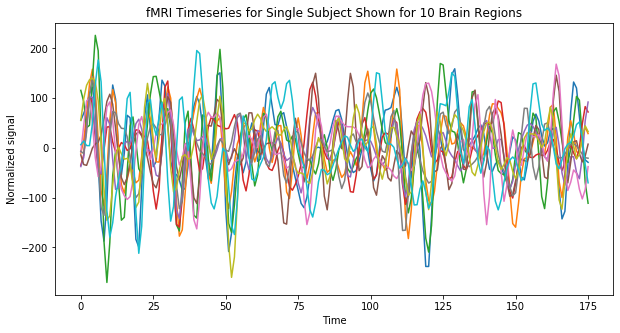

In [824]:
# each subject has 160 averaged fmri signals, each fmri signal includes 176 time points
# let's plot fmri signals for subject0 (dim0), for all time points (dim1), and for the first 10 brain regions (dim2)
plt.figure(figsize=(10,5))
plt.plot(dos160[0, :, 0:10])
plt.title('fMRI Timeseries for Single Subject Shown for 10 Brain Regions')
plt.xlabel('Time')
plt.ylabel('Normalized signal')
plt.show()

### 2.2  Compute Brain Connectivity Networks

In [825]:
# We mentioned dosenbach 160 atlas, but what does it mean? we can also fetch the atlas data from nilearn
atlas = fetch_coords_dosenbach_2010()
# it contains 3d coordinate (rois), label name, and network name for each brain region, and a general description
print(atlas.keys())
# obtain 3d coordinate from the atlas
coords = np.vstack((atlas.rois['x'], atlas.rois['y'], atlas.rois['z'])).T
print(coords.shape)
# we can display the coordinate to have a general idea about where these brain regions locate
view = plotting.view_markers(coords, title='Dosenbach 160 coordinates')
# view

dict_keys(['rois', 'labels', 'networks', 'description'])
(160, 3)


C:\Users\aprup\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [826]:
# print the names of those brain regions
# let's print the label names for the first 20 brain regions
print('label names for the first 20 brain region:\n', atlas.labels[0:20], '\n')

# each brain region may belong to a brain network that conducts specific functions
# let's print the network names for the first 20 brain regions
print('network names for the first 20 brain region:\n', atlas.networks[0:20], '\n')
# these brain regions can be devided into 6 networks in total
print('all network names:\n', np.unique(atlas.networks))

label names for the first 20 brain region:
 ["b'inf cerebellum' 155" "b'inf cerebellum' 150" "b'inf cerebellum' 151"
 "b'inf cerebellum' 140" "b'inf cerebellum' 131" "b'inf cerebellum' 122"
 "b'inf cerebellum' 121" "b'inf cerebellum' 110" "b'lat cerebellum' 128"
 "b'lat cerebellum' 113" "b'lat cerebellum' 109" "b'lat cerebellum' 98"
 "b'med cerebellum' 143" "b'med cerebellum' 144" "b'med cerebellum' 138"
 "b'med cerebellum' 130" "b'med cerebellum' 127" "b'med cerebellum' 120"
 "b'ACC' 19" "b'TPJ' 125"] 

network names for the first 20 brain region:
 [b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum'
 b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum'
 b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum' b'cerebellum'
 b'cerebellum' b'cerebellum' b'cerebellum' b'cingulo-opercular'
 b'cingulo-opercular'] 

all network names:
 [b'cerebellum' b'cingulo-opercular' b'default' b'fronto-parietal'
 b'occipital' b'sensorimotor']


(150, 160, 160)
<class 'numpy.ndarray'>


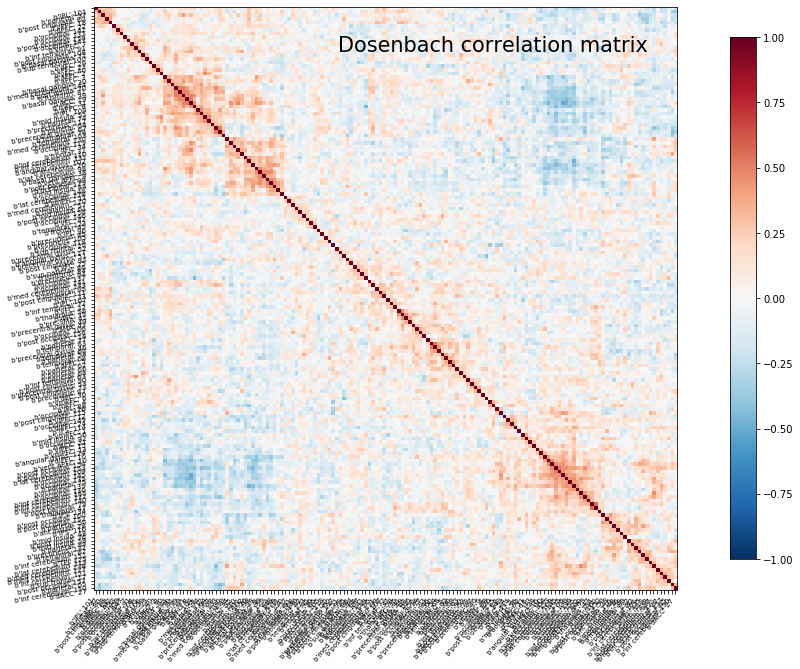

In [827]:
# for each subject, we can calculate pairwise correlation for those averaged fmri signals,
# resulting in a 150x160x160 array showing the strength of connectivity between two brain regions
conn_est = ConnectivityMeasure(kind='correlation').fit_transform(dos160)
print(conn_est.shape)
print(type(conn_est))
# we can visualize this connectivity matrix
plotting.plot_matrix(conn_est[3], vmin=-1., vmax=1., colorbar=True, labels=atlas.labels, title='Dosenbach correlation matrix', figure=(12, 12), reorder=True)
plt.show()

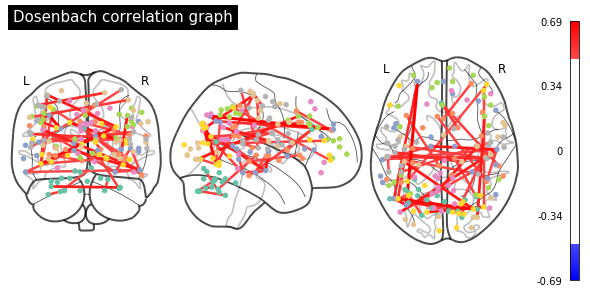

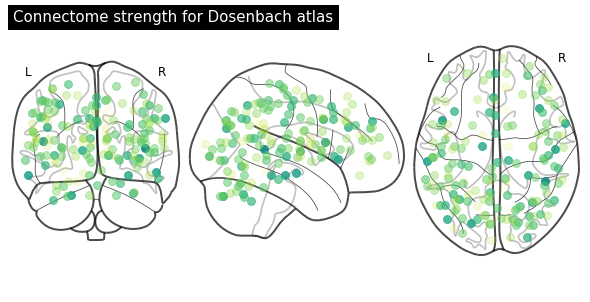

In [828]:
# we can also visualize the connectivity strength in the brain coordinates
# draw the connections with edge strength above 99.7%
fig1 = plt.figure(figsize=(8, 4))
plotting.plot_connectome(conn_est[0], coords, title='Dosenbach correlation graph', edge_threshold="99.7%", node_size=20, colorbar=True, figure=fig1)
# draw each node, the color represents the sum of absolute values of the edges stength arriving to a node
fig2 = plt.figure(figsize=(8, 4))
plotting.plot_connectome_strength(conn_est[0], coords, title='Connectome strength for Dosenbach atlas', figure=fig2)
plt.show()

## 3 Data Analysis

### 3.1  Comparing two means

Data Science Portion:

Standard Deviations
12.884548875416312 16.27419814309991
12.118756781451546 15.790492835510634
13.77929390220026 17.147328128400186

Shapiro Wilk test for control FIQ:  (0.9880488514900208, 0.7000299096107483)
Shapiro Wilk test for ASD FIQ:  (0.9747368097305298, 0.14418500661849976)
Shapiro Wilk test for control VIQ:  (0.9855482578277588, 0.5435594320297241)
Shapiro Wilk test for ASD VIQ:  (0.9795886278152466, 0.27542346715927124)
Shapiro Wilk test for control PIQ:  (0.9833112955093384, 0.4187769889831543)
Shapiro Wilk test for ASD PIQ:  (0.9769530296325684, 0.19450470805168152)

FIQ Data
Null Hypothesis: There is no difference between the FIQ measures of the ASD and control groups.
Alternative Hypothesis: There is a difference between the FIQ measures of the ASD and control groups.
Hypothesis Test Used: two-sample t-test
FIQ Data Test Statistic: 2.3607103984523254
FIQ Data P-Value: 0.01954373582577439

VIQ Data
Null Hypothesis: There is no difference between the VIQ measures of the AS

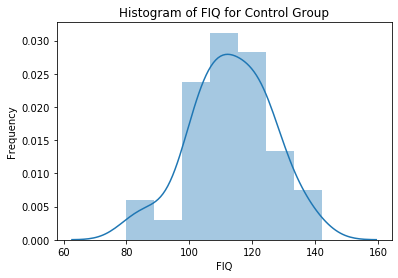

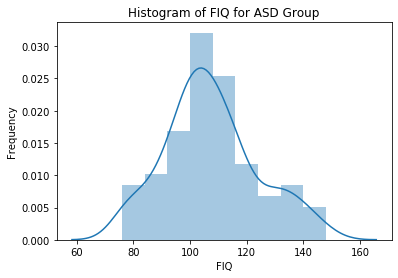

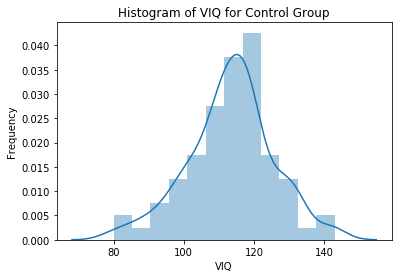

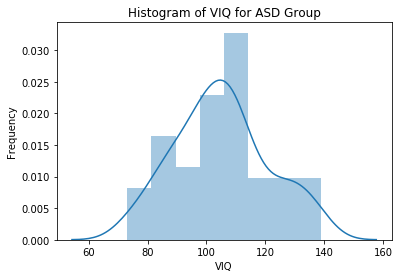

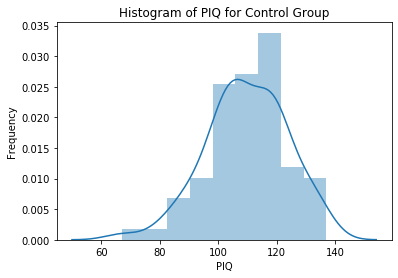

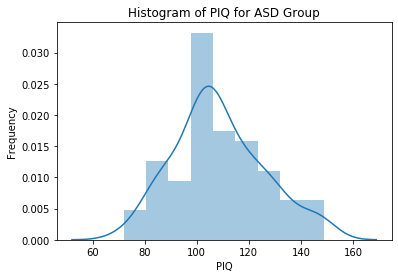

In [829]:
# Want to compare IQ measures between ASD and control group
# For PIQ, VIQ, FIQ, draw histograms of the values form the ASD and control groups
# Test hypothesis that there is no difference in the pIQ scores between the ASD and control groups
# Repeat hypothesis test for VIQ an FIQ scores
# For each of the three tests, state hypothesis, test used, test statistic, and p-value
# Include any additional tests to check if data meets assumptions

# adding edge weights to phenotypic data frame
n_nodes = 160
edge_vec = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] 
    edgeVec = connEst[np.triu_indices(n_nodes,1)]
    edgeVecMean = np.mean(edgeVec)
    edge_vec.append(edgeVecMean)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['avg_edge_weight'] = edge_vec

# separating phenotypic data between control and ASD
control = phenotypic[phenotypic['DX_GROUP']==2]
ASD = phenotypic[phenotypic['DX_GROUP']==1]

# obtaining FIQ, VIQ, PIQ per group
control_FIQ = control['FIQ']
ASD_FIQ = ASD['FIQ']
control_VIQ = control['VIQ']
ASD_VIQ = ASD['VIQ']
control_PIQ = control['PIQ']
ASD_PIQ = ASD['PIQ']

# calculating standard deviations
print('Standard Deviations')
std_control_FIQ = np.std(control_FIQ)
std_ASD_FIQ = np.std(ASD_FIQ)
print(std_control_FIQ, std_ASD_FIQ)
std_control_VIQ = np.std(control_VIQ)
std_ASD_VIQ = np.std(ASD_VIQ)
print(std_control_VIQ, std_ASD_VIQ)
std_control_PIQ = np.std(control_PIQ)
std_ASD_PIQ = np.std(ASD_PIQ)
print(std_control_PIQ, std_ASD_PIQ)
space(1)

# checking for normalcy
print('Shapiro Wilk test for control FIQ: ', stats.shapiro(control_FIQ))
print('Shapiro Wilk test for ASD FIQ: ', stats.shapiro(ASD_FIQ))
print('Shapiro Wilk test for control VIQ: ', stats.shapiro(control_VIQ))
print('Shapiro Wilk test for ASD VIQ: ', stats.shapiro(ASD_VIQ))
print('Shapiro Wilk test for control PIQ: ', stats.shapiro(control_PIQ))
print('Shapiro Wilk test for ASD PIQ: ', stats.shapiro(ASD_PIQ))
space(1)

# conducting tests on IQ measures
print('FIQ Data')
print('Null Hypothesis: There is no difference between the FIQ measures of the ASD and control groups.')
print('Alternative Hypothesis: There is a difference between the FIQ measures of the ASD and control groups.')
print('Hypothesis Test Used: two-sample t-test')
tStatFIQ, pvalueFIQ = scipy.stats.ttest_ind(control_FIQ, ASD_FIQ, equal_var=True)
print('FIQ Data Test Statistic:', tStatFIQ)
print('FIQ Data P-Value:', pvalueFIQ)
space(1)
print('VIQ Data')
print('Null Hypothesis: There is no difference between the VIQ measures of the ASD and control groups.')
print('Alternative Hypothesis: There is a difference between the VIQ measures of the ASD and control groups.')
print('Hypothesis Test Used: two-sample t-test')
tStatVIQ, pvalueVIQ = scipy.stats.ttest_ind(control_VIQ, ASD_VIQ, equal_var=True)
print('VIQ Data Test Statistic:', tStatVIQ)
print('VIQ Data P-Value:', pvalueVIQ)
space(1)
print('PIQ Data')
print('Null Hypothesis: There is no difference between the PIQ measures of the ASD and control groups.')
print('Alternative Hypothesis: There is a difference between the PIQ measures of the ASD and control groups.')
print('Hypothesis Test Used: two-sample t-test')
tStatPIQ, pvaluePIQ = scipy.stats.ttest_ind(control_PIQ, ASD_PIQ, equal_var=True)
print('PIQ Data Test Statistic:', tStatPIQ)
print('PIQ Data P-Value:', pvaluePIQ)

sns.distplot(control_FIQ)
plt.title('Histogram of FIQ for Control Group')
plt.xlabel('FIQ')
plt.ylabel('Frequency')
plt.show()
sns.distplot(ASD_FIQ)
plt.title('Histogram of FIQ for ASD Group')
plt.xlabel('FIQ')
plt.ylabel('Frequency')
plt.show()
sns.distplot(control_VIQ)
plt.title('Histogram of VIQ for Control Group')
plt.xlabel('VIQ')
plt.ylabel('Frequency')
plt.show()
sns.distplot(ASD_VIQ)
plt.title('Histogram of VIQ for ASD Group')
plt.xlabel('VIQ')
plt.ylabel('Frequency')
plt.show()
sns.distplot(control_PIQ)
plt.title('Histogram of PIQ for Control Group')
plt.xlabel('PIQ')
plt.ylabel('Frequency')
plt.show()
sns.distplot(ASD_PIQ)
plt.title('Histogram of PIQ for ASD Group')
plt.xlabel('PIQ')
plt.ylabel('Frequency')
plt.show()

Essay Portion:

This is a two-sample design rather than a paired sample design because (1) the ASD and control groups are not the same sizes and (2) there is no way to pair the data. The test I chose was the two-sample t-test for equal means. <br>
<br>
For this test, the assumptions are that each group has a normal distribution, and that the standard deviation (and thus variances) are the same for both groups for each test). Upon calculating standard deviations, conducting Shapiro Wilk tests, and plotting histograms, we see that these assumptions pass for each of the three tests (for FIQ, VIQ, and PIQ). <br>
<br>
For the FIQ data, the test statistic was 2.3607103984523254 and the corresponding p-value was 0.01954373582577439. Using a alpha significance level of 0.05, we are able to reject the null hypothesis and assume the alternative hypothesis, which is that the control and ASD groups have different FIQ measures. <br>
<br>
For the VIQ data, the test statistic was 3.575728257746529 and the corresponding p-value was 0.00047220420484005637. Using a alpha significance level of 0.05, we are able to reject the null hypothesis and assume the alternative hypothesis, which is that the control and ASD groups have different FIQ measures. <br>
<br>
For the VIQ data, the test statistic was 0.44770228871091905 and the corresponding p-value was 0.6550226848952008. Using a alpha significance level of 0.05, we are not able to reject the null hypothesis, which was that there is no difference in the PIQ measures between the control and ASD groups. <br>
<br>
While two IQ measures gave significant differences between ASD and Control individuals, PIQ did not. Thus, only FIQ and VIQ would be indicative as a diagnostic tool; PIQ would not. 

### 3.2  Detecting deviations from normality

Data Science Portion:

Standard deviation for control average edge weights:  0.002758626153879117
Standard deviation for ASD average edge weights:  0.003095816184806056
Shapiro Wilk test for control average edge weights:  (0.952130913734436, 0.006084357853978872)
Shapiro Wilk test for ASD average edge weights:  (0.9551755785942078, 0.010372789576649666)
Standard deviation for transformed control average edge weights:  0.019515473725533167
Standard deviation for transformed ASD average edge weights:  0.021603346384387836
Shapiro Wilk test for transformed control average edge weights:  (0.9845154285430908, 0.48348331451416016)
Shapiro Wilk test for transformed ASD average edge weights:  (0.9898359179496765, 0.8223918676376343)


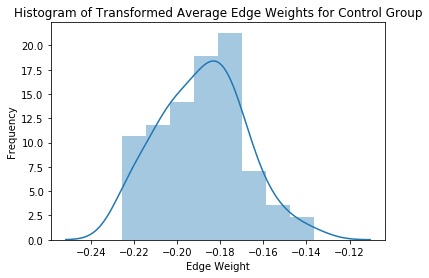

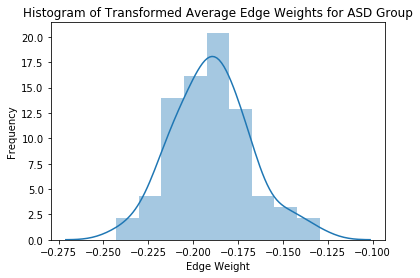

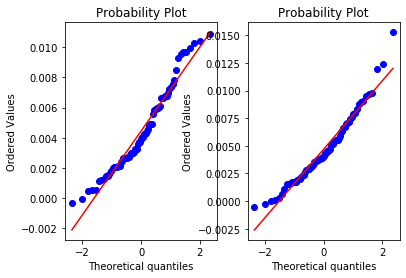

In [830]:
## It may be helpful to extract the edge weights from one matrix. This is the same as extracting all the
# upper triangular entries (those above the diagonal).
# conn_est is the 150 160x160 matrices
# conn_est[3] is the 160x160 matrix for subject 3

numberSubjects = conn_est.shape[0] # total number of subjects
# print(numberSubjects)

# separating data into control and ASD
edge_vec_control = control['avg_edge_weight']
edge_vec_ASD = ASD['avg_edge_weight']

# now, have lists of edge weights for ASD and Control
# checking for variance
print('Standard deviation for control average edge weights: ', np.std(edge_vec_control))
print('Standard deviation for ASD average edge weights: ', np.std(edge_vec_ASD))
# the standard deviation difference is NOT three-fold
# we have to check for normal distribututions, using the Shapiro Wilk test
print('Shapiro Wilk test for control average edge weights: ', stats.shapiro(edge_vec_control))
print('Shapiro Wilk test for ASD average edge weights: ', stats.shapiro(edge_vec_ASD))
# they are NOT normally distributed according to Shapiro Wilk, and we must conduct a transform

# adding 0.001, log transform, then reciprocal 
K = 0.001
edge_vec_control_transform = [x + K for x in edge_vec_control] 
edge_vec_ASD_transform = [x + K for x in edge_vec_ASD]
edge_vec_control_transform = np.log(edge_vec_control_transform)
edge_vec_ASD_transform = np.log(edge_vec_ASD_transform)
edge_vec_control_transform = 1/(edge_vec_control_transform)
edge_vec_ASD_transform = 1/(edge_vec_ASD_transform)

# checking for variance
print('Standard deviation for transformed control average edge weights: ', np.std(edge_vec_control_transform))
print('Standard deviation for transformed ASD average edge weights: ', np.std(edge_vec_ASD_transform))
# Shapiro Wilk test on transformed data
print('Shapiro Wilk test for transformed control average edge weights: ', stats.shapiro(edge_vec_control_transform))
print('Shapiro Wilk test for transformed ASD average edge weights: ', stats.shapiro(edge_vec_ASD_transform))

# now, to visualize the data
sns.distplot(edge_vec_control_transform)
plt.title('Histogram of Transformed Average Edge Weights for Control Group')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.show()
sns.distplot(edge_vec_ASD_transform)
plt.title('Histogram of Transformed Average Edge Weights for ASD Group')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.show()

# normal quantile plots
plt.subplot(1,2,1)
stats.probplot(edge_vec_control, dist = 'norm', plot=plt)
plt.subplot(1,2,2)
stats.probplot(edge_vec_ASD, dist = 'norm', plot=plt)
plt.show()

Essay Portion:

The normal quantile plots tell us about the distributions and normalcy of the original data. We see that the theoretical quantiles do not quite line up with the orderd values of the given data. From the Shapiro-Wilk tests, we learn that the data are not initially normal. I used a triple-paired transformation (adding 0.001, log transform, and reciprocal transform). I didn't try other transformations, because the arcsin and square transformations require that all numbers are the same sign in a single population (which we don't have). 

### 3.3  Nonparametric tests 

Data Science Portion:

In [807]:
# Mann Whitney U-Test on untransformed
print('Mann Whitney U-Test Results on Untransformed Data:', stats.mannwhitneyu(edge_vec_control, edge_vec_ASD, use_continuity=True, alternative=None))
# Mann Whitney U-Test on transformed
print('Mann Whitney U-Test Results on Transformed Data:', stats.mannwhitneyu(edge_vec_control_transform, edge_vec_ASD_transform, use_continuity=True, alternative=None))

# Two-Sample t-test on untransformed
print('Welchs Two Sample T-Test on Untransformed Data:', stats.ttest_ind(edge_vec_ASD, edge_vec_control, equal_var=False))
# Two-Sample t-test on transformed
print('Welchs Two Sample T-Test on Transformed Data:', stats.ttest_ind(edge_vec_ASD_transform, edge_vec_control_transform, equal_var=False))

Mann Whitney U-Test Results on Untransformed Data: MannwhitneyuResult(statistic=2707.0, pvalue=0.3472254834976831)
Mann Whitney U-Test Results on Transformed Data: MannwhitneyuResult(statistic=2707.0, pvalue=0.3472254834976831)
Welchs Two Sample T-Test on Untransformed Data: Ttest_indResult(statistic=0.5197852155766414, pvalue=0.6040054064726923)
Welchs Two Sample T-Test on Transformed Data: Ttest_indResult(statistic=-0.3155871450008406, pvalue=0.752767767273615)


Essay Portion:

Null Hypothesis: There is no difference in average edge weight between the ASD and control groups. <br>
<br>
Alternative Hypothesis: There is A difference in average edge weight between the ASD and control groups. <br>
<br>
The assumptions of the Two-Sample T-test are that both samples are randomly sampled, that the numerical variables have normal distributions, and that the standard deviations are the same. <br>
<br> Non-parametric tests makes less assumptions than do parametric tests about the distributions of the variables. The assumptions are that the groups are randomly sampled, and that the distributions have the same variance and same skew (together, shape). <br>
<br>
The average functional connectivity edge weight would not be a great diagnostic tool to differentiate between Control and ASD individuals, because the p-value of the two-sample t-test was now lower than our alpha significane value, so we cannot reject the null hypothesis, which is that there is no difference in average edge weight between ASD and control group. Thus, this measure is not very indicative. 

### 3.4  ANOVA

Data Science Portion:

In [808]:
# Extracting data
# adding edge weights to phenotypic data frame
n_nodes = 160
edge_vec = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] 
    edgeVec = connEst[np.triu_indices(n_nodes,1)]
    edgeVecMean = np.mean(edgeVec)
    edge_vec.append(edgeVecMean)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['avg_edge_weight'] = edge_vec

ASD = phenotypic[phenotypic['DSM_IV_TR']==1]
aspergers = phenotypic[phenotypic['DSM_IV_TR']==2]
PDD_NOS = phenotypic[phenotypic['DSM_IV_TR']==3]

# gathering array of FIQ values for each group
ASD_FIQ = ASD['FIQ']
aspergers_FIQ = aspergers['FIQ']
PDD_NOS_FIQ = PDD_NOS['FIQ']

# performing ANOVA on FIQ data
print(scipy.stats.f_oneway(ASD_FIQ, aspergers_FIQ, PDD_NOS_FIQ))
space(1)
# perform Tukey-test to determine differing group
phenotypic123 = phenotypic[(phenotypic['DSM_IV_TR']>=1) & (phenotypic['DSM_IV_TR']<=3)]
print(pairwise_tukeyhsd(phenotypic123['FIQ'], phenotypic123['DSM_IV_TR'], 0.05))

# gathering array of edge weight values for each group
ASD_edge_weight = ASD['avg_edge_weight']
aspergers_edge_weight = aspergers['avg_edge_weight']
PDD_NOS_edge_weight = PDD_NOS['avg_edge_weight']
space(1)
# performing ANOVA on edge weights data
print(scipy.stats.f_oneway(ASD_edge_weight, aspergers_edge_weight, PDD_NOS_edge_weight))
space(1)
# perform Tukey-test to determine differing group
# print(pairwise_tukeyhsd(phenotypic123['avg_edge_weight'], phenotypic123['DSM_IV_TR'], 0.05))

# CREATING ANOVA TABLE

#tabulating data 
phenotypic123 = phenotypic[(phenotypic['DSM_IV_TR']>=1) & (phenotypic['DSM_IV_TR']<=3)]

SSB_ASD_FIQ = len(ASD_FIQ)*((np.mean(ASD_FIQ)-np.mean(phenotypic123['FIQ']))**2) 
SSB_aspergers_FIQ = len(aspergers_FIQ)*((np.mean(aspergers_FIQ)-np.mean(phenotypic123['FIQ']))**2) 
SSB_PDD_NOS_FIQ = len(PDD_NOS_FIQ)*((np.mean(PDD_NOS_FIQ)-np.mean(phenotypic123['FIQ']))**2) 
SSB_FIQ = SSB_ASD_FIQ + SSB_aspergers_FIQ + SSB_PDD_NOS_FIQ
print("The SSB value is", SSB_FIQ)

k = 3
ddof = k - 1
MSB_FIQ = SSB_FIQ/ddof
print("The MSB value is", MSB_FIQ)

a = sum((np.array(ASD_FIQ) - np.mean(ASD_FIQ))**2)
b = sum((np.array(aspergers_FIQ) - np.mean(aspergers_FIQ))**2)
c = sum((np.array(PDD_NOS_FIQ) - np.mean(PDD_NOS_FIQ))**2)
SSW_FIQ = a + b + c
print("The SSW value is", SSW_FIQ)

MSE_FIQ = SSW_FIQ/(len(phenotypic123['FIQ']) - 3)
print("The MSE value is", MSE_FIQ)

F_FIQ = MSB_FIQ/MSE_FIQ

print(f"The f statistic is {F_FIQ}")

FIQ_Data= [SSB_ASD_FIQ,MSB_FIQ,SSW_FIQ,MSE_FIQ,F_FIQ]
indexes=["SSB","SSB","SSW","MSE","f-stat"]
Des=["SSB is the group mean square estimates the variance among subjects that belong to different groups",
    "MSB is the mean square between and is based on differences among the sample means",
    "SSW is the sum of squares within and it measures the sum dispersion amoung the values in the same group",
    "MSE is error mean square which represents the pooled sample variance",
    "The f statistic is the ratio of the between estimate of variance and the within estimate of variance"]

ANOVA_dict={'FIQ': FIQ_Data,'Description':Des}
df_ANOVA = pd.DataFrame(data=ANOVA_dict, index=indexes)
df_ANOVA


F_onewayResult(statistic=3.751957629879428, pvalue=0.028250726750358272)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  11.3889  0.028   1.0191 21.7587   True
     1      3      8.6 0.4816  -9.1252 26.3252  False
     2      3  -2.7889    0.9 -21.9098  16.332  False
-----------------------------------------------------

F_onewayResult(statistic=2.1150355022600182, pvalue=0.12816638454935364)

The SSB value is 1873.3870870870858
The MSB value is 936.6935435435429
The SSW value is 17725.477777777778
The MSE value is 249.6546165884194
The f statistic is 3.751957629879426


,FIQ,Description
SSB,572.809350,SSB is the group mean square estimates the var...
SSB,936.693544,MSB is the mean square between and is based on...
SSW,17725.477778,SSW is the sum of squares within and it measur...
MSE,249.654617,MSE is error mean square which represents the ...
f-stat,3.751958,The f statistic is the ratio of the between es...


Essay Portion:

The assumptions of the ANOVA test are that the variable is normally distributed with equal standard deviations (and thus equal variances) in all k populations, and that each sample is random. The data did fit these assumptions. I ran a Tukey-Krmaer test because this allows us to see the data group for which the mean differed in the results of FIQ. The results from the IQ ANOVA revealed that group did differ from the others (p-value < 0.05). The results from the edge weight ANOVA told us that a group did not significantly differ in terms of edge weight (p-value > 0.05). If a significant result were found for edge weights, I would have run a Tukey-Kramer test. If we were looking for a diagnostic tool that distringuished between the three groups, the results would tell us that average edge weight would not be a good indicator of this. FIQ seems like a more viable tool, but other tests similar in nature to FIQ may give us more distinguishible results, so we could head in that direction

### 3.5  Correlation coefficients

Data Science Portion:

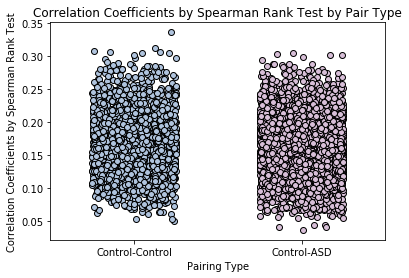

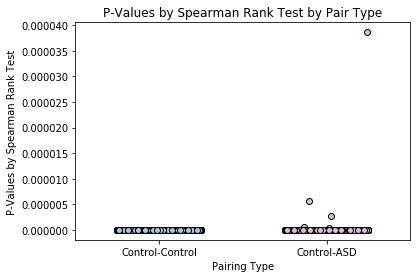

In [809]:
# looking at individual edge weights rather than average edge weights
phenotypic = abide.phenotypic
phenotypic = pd.DataFrame(phenotypic)
# adding edge weights to phenotypic data frame
n_nodes = 160
edge_vec = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] 
    edgeVec = connEst[np.triu_indices(n_nodes,1)]
    edgeVecMean = np.mean(edgeVec)
    edge_vec.append(edgeVecMean)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['avg_edge_weight'] = edge_vec
# separating data between control and ASD
conn_est_control = conn_est[phenotypic['DX_GROUP']==2]
numberControl = len(conn_est_control)
conn_est_ASD = conn_est[phenotypic['DX_GROUP']==1]
numberASD = len(conn_est_ASD)

# gathering edge vectors for ASD and control data
n_nodes = 160
edgeVectorControl = []
for x in range(0, numberControl):
    connEstControl = conn_est_control[x] 
    edgeVecControl = connEstControl[np.triu_indices(n_nodes,1)] 
    edgeVectorControl.append(edgeVecControl)

edgeVectorASD = []
for x in range(0, numberASD):
    connEstASD = conn_est_ASD[x] 
    edgeVecASD = connEstASD[np.triu_indices(n_nodes,1)]
    edgeVectorASD.append(edgeVecASD)
    
# calculating correlation coefficients
rho_Control_Control = []
pVal_Control_Control = []
for x in range(0, len(edgeVectorControl)):
    for y in range(x+1, len(edgeVectorControl)):
        edgeVecControl1 = edgeVectorControl[x]
        edgeVecControl2 = edgeVectorControl[y]
        rho, pVal = stats.spearmanr(edgeVecControl1, edgeVecControl2)
        rho_Control_Control.append(rho)
        pVal_Control_Control.append(pVal)
        
rho_Control_ASD = []
pVal_Control_ASD = []
for x in range(0, len(edgeVectorControl)):
    for y in range(0, len(edgeVectorASD)):
        edgeVecControl = edgeVectorControl[x]
        edgeVecASD = edgeVectorASD[y]
        rho, pVal = stats.spearmanr(edgeVecControl, edgeVecASD)
        rho_Control_ASD.append(rho)
        pVal_Control_ASD.append(pVal)

# Creating the strip plot for correlation coefficients
x_rho_Control_Control= [0.5] * len(rho_Control_Control) + np.random.random_sample(len(rho_Control_Control))
x_rho_Control_ASD = [2.5] * len(rho_Control_ASD) + np.random.random_sample(len(rho_Control_ASD))
plt.plot(x_rho_Control_Control, rho_Control_Control, color = 'lightsteelblue', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(x_rho_Control_ASD, rho_Control_ASD, color = 'thistle', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.xlim(0,4)
plt.xticks(range(1, 4, 2), ['Control-Control', 'Control-ASD'])
plt.ylabel('Correlation Coefficients by Spearman Rank Test')
plt.xlabel('Pairing Type')
plt.title('Correlation Coefficients by Spearman Rank Test by Pair Type')
plt.show()

# Creating the strip plot for p-values
x_pVal_Control_Control= [0.5] * len(pVal_Control_Control)  + np.random.random_sample(len(pVal_Control_Control))
x_pVal_Control_ASD = [2.5] * len(pVal_Control_ASD) + np.random.random_sample(len(pVal_Control_ASD))
plt.plot(x_pVal_Control_Control, pVal_Control_Control, color = 'lightsteelblue', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(x_pVal_Control_ASD, pVal_Control_ASD, color = 'thistle', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.xlim(0,4)
plt.xticks(range(1, 4, 2), ['Control-Control', 'Control-ASD'])
plt.ylabel('P-Values by Spearman Rank Test')
plt.xlabel('Pairing Type')
plt.title('P-Values by Spearman Rank Test by Pair Type')
plt.show()


Essay Portion:

I used a Spearman Rank correlation for this data. Since we know that the patient group has more subtypes, which may lead to a lower association between each other. The healthy group may just look more “similarly healthy”. Thus, we do see what we expected by comparing the correlation for ASD vs. ASD and for ASD vs. Control. 

### 3.6  Linear Regression

Data Science Portion:

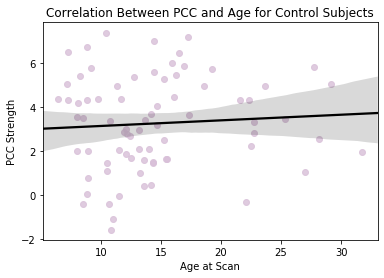

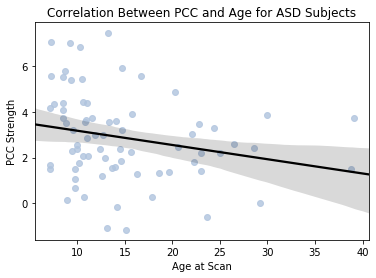


Lines of Best Fit:
Control: y = 0.025477667537451745*x + 2.884224706581053
ASD: y = -0.06224047445566539*x + 3.795196938625205

ASD subject ages range from 7.13 to 39.1
Control subject ages range from 6.47 to 31.78

Correlation of Age and PCC Strength for Control Subjects: 0.09784206103344263
Correlation of Age and PCC Strength for ASD Subjects: -0.28298296155730585
Standard deviation for transformed control average edge weights:  2.0979571248268467
Standard deviation for transformed ASD average edge weights:  1.9011265109707407
Shapiro Wilk test for transformed control average edge weights:  (0.9854556322097778, 0.5380181670188904)
Shapiro Wilk test for transformed ASD average edge weights:  (0.9826887845993042, 0.40628334879875183)


In [810]:
# PCC = 70th node in matrix, but since Python starts at 0, we use 69th column for this
phenotypic = abide.phenotypic
# adding edge weights to phenotypic data frame
n_nodes = 160
edge_vec = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] 
    edgeVec = connEst[np.triu_indices(n_nodes,1)]
    edgeVecMean = np.mean(edgeVec)
    edge_vec.append(edgeVecMean)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['avg_edge_weight'] = edge_vec

# adding PCC to phenotypic data frame
n_nodes = 160
PCC = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] # getting specific 160x160 matrix for the subject
    PCC_subject = sum(connEst[:, 69])
    PCC.append(PCC_subject)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['PCC'] = PCC

# separating phenotypic data between control and ASD
control = phenotypic[phenotypic['DX_GROUP']==2]
ASD = phenotypic[phenotypic['DX_GROUP']==1]

# obtaining ages per group
control_age = control['AGE_AT_SCAN']
ASD_age = ASD['AGE_AT_SCAN']

# obtaining PCC's per group
control_PCC = control['PCC']
ASD_PCC = ASD['PCC']

# lines of best fit
m1, b1 = np.polyfit(control_age, control_PCC, 1)
m2, b2 = np.polyfit(ASD_age, ASD_PCC, 1)

# plt.scatter(control_age, control_PCC, color = 'thistle')
# plt.plot(control_age, m1*control_age + b1, color = 'violet')
sns.regplot(control_age, control_PCC, color = 'thistle', line_kws={"color": "black", "label": "fit"})
plt.ylabel('PCC Strength')
plt.xlabel('Age at Scan')
plt.title('Correlation Between PCC and Age for Control Subjects')
plt.show()

# plt.scatter(ASD_age, ASD_PCC, color = 'lightsteelblue')
# plt.plot(ASD_age, m2*ASD_age + b2, color = 'steelblue')
sns.regplot(ASD_age, ASD_PCC, color = 'lightsteelblue', line_kws={"color": "black", "label": "fit"})
plt.ylabel('PCC Strength')
plt.xlabel('Age at Scan')
plt.title('Correlation Between PCC and Age for ASD Subjects')
plt.show()
space(1)
print('Lines of Best Fit:')
print(f'Control: y = {m1}*x + {b1}')
print(f'ASD: y = {m2}*x + {b2}')
space(1)

# finding minimums and maximums of the data range
print(f'ASD subject ages range from {min(ASD_age)} to {max(ASD_age)}')
print(f'Control subject ages range from {min(control_age)} to {max(control_age)}')
space(1)

# calculating correlations
control_rho, control_pVal = stats.spearmanr(control_age, control_PCC)
ASD_rho, ASD_pVal = stats.spearmanr(ASD_age, ASD_PCC)
print(f'Correlation of Age and PCC Strength for Control Subjects: {control_rho}')
print(f'Correlation of Age and PCC Strength for ASD Subjects: {ASD_rho}')

# normalcy and variance
# checking for variance
print('Standard deviation for transformed control average edge weights: ', np.std(control_PCC))
print('Standard deviation for transformed ASD average edge weights: ', np.std(ASD_PCC))
# Shapiro Wilk test on transformed data
print('Shapiro Wilk test for transformed control average edge weights: ', stats.shapiro(control_PCC))
print('Shapiro Wilk test for transformed ASD average edge weights: ', stats.shapiro(ASD_PCC))


Essay Portion:

Assumptions: at each age value, the data for PCC strength should be normally distributed; the variance should be equal for all ages; the PCC strength should be random, the relationship should be linear. <br>
<br>
Our data does fit the above assumptions. From the r^2 value, we learned about how well the linear regression fit the data. We also get the slope from the linear regression calculations. We would be able to calculate expected PCC strength for a teenager (since they are within the domain), but not a child of age 2 (this would be extrapolating and possibly inaccurate beyond our domain).

### 3.7  Linear Regression and statistical testing

Data Science Portion:

ASD subject ages range from 7.13 to 39.1
Control subject ages range from 6.47 to 31.78
All subject ages range from 6.47 to 39.1



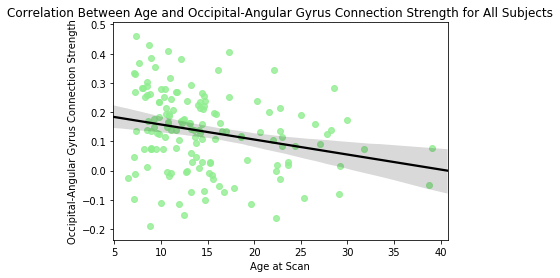


Slope for All:  -0.005133384904638533
Intercept for All:  0.20908361281217747
R-Value for All: -0.24961221376584922
P-Value for All: 0.002066872020487259
Standard Error for All: 0.0025825344266005674
Line of Best Fit for All: y = -0.004764502737004436*x + 0.20908361281217747
The 95% confidence interval for All is [-0.008341823410330297, -0.0019249463989467687]



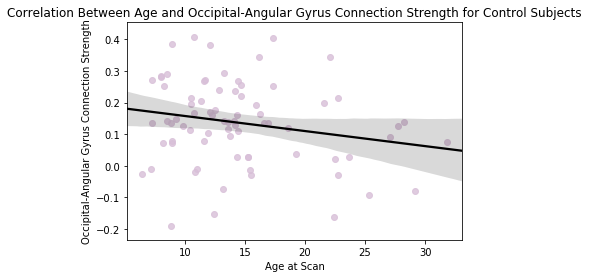


Slope for Control:  -0.004764502737004436
Intercept for Control:  0.2052025713575138
R-Value for Control: -0.20969630805371886
P-Value for Control: 0.06905437861211
Standard Error for Control: 0.0025825344266005674
Line of Best Fit for Control: y = -0.004764502737004436*x + 0.2052025713575138
The 95% confidence interval for Control is [-0.009826270213141548, 0.0002972647391326763]



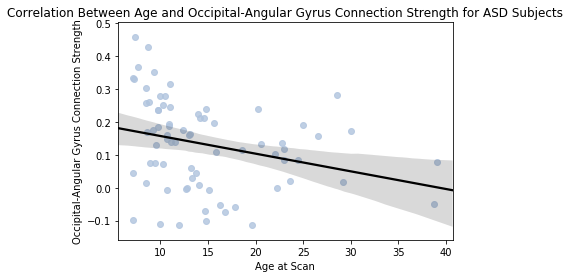


Slope for ASD:  -0.005376362464408281
Intercept for ASD:  0.21116815121395063
R-Value for ASD: -0.28354725413031484
P-Value for ASD: 0.01436077139984703
Standard Error for ASD: 0.0021428735927358274
Line of Best Fit for ASD: y = -0.005376362464408281*x + 0.21116815121395063
The 95% confidence interval for ASD is [-0.009576394706170503, -0.0011763302226460593]


In [811]:
phenotypic = abide.phenotypic
from sklearn import linear_model
# adding specific edge (61 and 55) to phenotypic data frame
n_nodes = 160
specificEdge = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] # getting specific 160x160 matrix for the subject
    specificEdge_subject = connEst[60, 54]
    specificEdge.append(specificEdge_subject)
    
phenotypic = pd.DataFrame(phenotypic)
phenotypic['61Nodex55Node_EDGE_WEIGHT'] = specificEdge

# separating phenotypic data between control and ASD
control = phenotypic[phenotypic['DX_GROUP']==2]
ASD = phenotypic[phenotypic['DX_GROUP']==1]

# obtaining ages per group
control_age = control['AGE_AT_SCAN']
all_age = phenotypic['AGE_AT_SCAN']
ASD_age = ASD['AGE_AT_SCAN']

# obtaining PCC's per group
control_6155_edgeWeight  = control['61Nodex55Node_EDGE_WEIGHT']
all_6155_edgeWeight = phenotypic['61Nodex55Node_EDGE_WEIGHT']
ASD_6155_edgeWeight  = ASD['61Nodex55Node_EDGE_WEIGHT']


# finding minimums and maximums of the data range
print(f'ASD subject ages range from {min(ASD_age)} to {max(ASD_age)}')
print(f'Control subject ages range from {min(control_age)} to {max(control_age)}')
print(f'All subject ages range from {min(all_age)} to {max(all_age)}')
space(1)

sns.regplot(all_age, all_6155_edgeWeight, color = 'lightgreen', line_kws={"color": "black", "label": "fit"})
plt.ylabel('Occipital-Angular Gyrus Connection Strength')
plt.xlabel('Age at Scan')
plt.title('Correlation Between Age and Occipital-Angular Gyrus Connection Strength for All Subjects')
plt.show()
space(1)


# linear regression for all data
slope, intercept, r_value, p_value, std_err = stats.linregress(all_age,all_6155_edgeWeight)
print('Slope for All: ', slope)
print('Intercept for All: ', intercept)
print('R-Value for All:', r_value)
print('P-Value for All:', p_value)
print('Standard Error for All:', std_err_control)
print(f'Line of Best Fit for All: y = {slope_control}*x + {intercept}')
confidence_lowerAll = slope - 1.96*std_err
confidence_upperAll = slope + 1.96*std_err                  
print(f"The 95% confidence interval for All is [{confidence_lowerAll}, {confidence_upperAll}]")
space(1)
# plt.scatter(control_age, control_6155_edgeWeight, color = 'thistle')
sns.regplot(control_age, control_6155_edgeWeight, color = 'thistle', line_kws={"color": "black", "label": "fit"})
# plt.plot(control_age, m1*control_6155_edgeWeight + b1, color = 'violet')
plt.ylabel('Occipital-Angular Gyrus Connection Strength')
plt.xlabel('Age at Scan')
plt.title('Correlation Between Age and Occipital-Angular Gyrus Connection Strength for Control Subjects')
plt.show()
space(1)
# linear regression for control
slope_control, intercept_control, r_value_control, p_value_control, std_err_control = stats.linregress(control_age,control_6155_edgeWeight)
print('Slope for Control: ', slope_control)
print('Intercept for Control: ', intercept_control)
print('R-Value for Control:', r_value_control)
print('P-Value for Control:', p_value_control)
print('Standard Error for Control:', std_err_control)
print(f'Line of Best Fit for Control: y = {slope_control}*x + {intercept_control}')
confidence_lowerControl = slope_control - 1.96*std_err_control
confidence_upperControl = slope_control + 1.96*std_err_control
print(f"The 95% confidence interval for Control is [{confidence_lowerControl}, {confidence_upperControl}]")

space(1)
# plt.scatter(ASD_age, ASD_6155_edgeWeight, color = 'lightsteelblue')
sns.regplot(ASD_age, ASD_6155_edgeWeight, color = 'lightsteelblue', line_kws={"color": "black", "label": "fit"})
# plt.plot(ASD_age, m2*ASD_age + b2, color = 'steelblue')
plt.ylabel('Occipital-Angular Gyrus Connection Strength')
plt.xlabel('Age at Scan')
plt.title('Correlation Between Age and Occipital-Angular Gyrus Connection Strength for ASD Subjects')
plt.show()
space(1)

# linear regression for ASD
slope_ASD, intercept_ASD, r_value_ASD, p_value_ASD, std_err_ASD = stats.linregress(ASD_age,ASD_6155_edgeWeight)
print('Slope for ASD: ', slope_ASD)
print('Intercept for ASD: ', intercept_ASD)
print('R-Value for ASD:', r_value_ASD)
print('P-Value for ASD:', p_value_ASD)
print('Standard Error for ASD:', std_err_ASD)
print(f'Line of Best Fit for ASD: y = {slope_ASD}*x + {intercept_ASD}')
confidence_lowerASD = slope_ASD - 1.96*std_err_ASD
confidence_upperASD = slope_ASD + 1.96*std_err_ASD
print(f"The 95% confidence interval for ASD is [{confidence_lowerASD}, {confidence_upperASD}]")

Essay Portion:

We can also calculate a more standard confidence interval for the slope. The 1-$\alpha$% confidence interval for the slope is:

$$ b - t_{\alpha(2),df}SE_b < \beta <  b + t_{\alpha(2),df}SE_b$$ <br>

The first hypothesis test tells us the slope is not 0. The new information we get is whether this slope differs between ASD and Control subjects. It's important to test the same hypothesis on the individual groups, because we cannot assume this based on the overall data. For example, if we had a very negative slope for one group of the data but a slighty positive one, the average would end up being still negative; however, this would not show us the differences in the data between the two groups. 

### 3.8  Permutation testing

Data Science Portion:

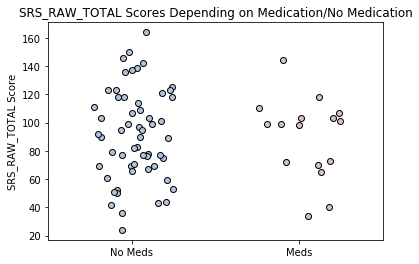

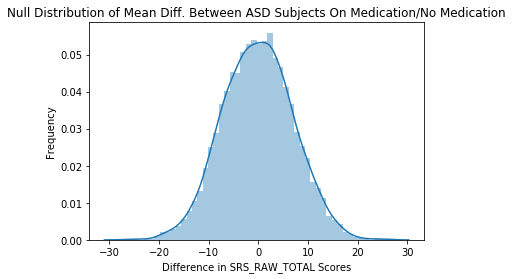

Test Statistic: -1.600877192982452
P-Value: 0.4211


In [812]:
phenotypic = abide.phenotypic
phenotypic['SRS_RAW_TOTAL']
# filtering out unwanted code
phenotypic = pd.DataFrame(phenotypic)
phenotypic = phenotypic.loc[(phenotypic['SRS_RAW_TOTAL']>=0)]
subset = []
# phenotypic = phenotypic.dropna()

phenotypic = pd.DataFrame(phenotypic)
df = phenotypic['CURRENT_MED_STATUS']

df = df.replace(to_replace= b'0', value=0)
df = df.replace(to_replace= b'1', value=1)
Med = df
# display(df) # making sure all became numbers

phenotypic['CURRENT_MED_STATUS'] = Med
# display(phenotypic['CURRENT_MED_STATUS'])

# only want ASD data
ASD = phenotypic[phenotypic['DX_GROUP'] == 1]
ASD_Meds = ASD[ASD['CURRENT_MED_STATUS'] == 1]
ASD_NoMeds = ASD[ASD['CURRENT_MED_STATUS'] == 0]
# now, have separated ASD subjects into those who take medication, and those who don't
ASD_Meds_SRS = ASD_Meds['SRS_RAW_TOTAL']
ASD_NoMeds_SRS = ASD_NoMeds['SRS_RAW_TOTAL']
# print(len(ASD_NoMeds_SRS))

# creating strip plot of differences
ASD_NoMeds_SRS = np.array(ASD_NoMeds_SRS)
ASD_Meds_SRS = np.array(ASD_Meds_SRS)
differ = []
for x in range(0, len(ASD_NoMeds_SRS)):
    for y in range(0, len(ASD_Meds_SRS)):
        specNoMed = ASD_NoMeds_SRS[x]
        specMed = ASD_Meds_SRS[y]
        differ.append(specNoMed-specMed)
        
# Creating the strip plot 
x_NoMeds = [0.5] * len(ASD_NoMeds_SRS) + np.random.random_sample(len(ASD_NoMeds_SRS))
x_Meds = [2.5] * len(ASD_Meds_SRS) + np.random.random_sample(len(ASD_Meds_SRS))
plt.plot(x_NoMeds, ASD_NoMeds_SRS, color = 'lightsteelblue', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(x_Meds, ASD_Meds_SRS, color = 'thistle', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.xlim(0,4)
plt.xticks(range(1, 4, 2), ['No Meds', 'Meds'])
plt.ylabel('SRS_RAW_TOTAL Score')
plt.title('SRS_RAW_TOTAL Scores Depending on Medication/No Medication')
plt.show()
        
#calculate test stat
noMeds_mean= np.mean(ASD_NoMeds_SRS)
Meds_mean= np.mean(ASD_Meds_SRS)
tStat= Meds_mean - noMeds_mean
# print(noMeds_mean)
# print('Test Statistic:', tStat)

# creating array of all 
SRS_RAW_scores = np.hstack((ASD_Meds_SRS, ASD_NoMeds_SRS))

# make null ditribution 
null = []
for i in range (10000):
    NoMeds_null= np.random.choice(SRS_RAW_scores,len(ASD_NoMeds_SRS),replace = False)
    Meds_null = np.random.choice(SRS_RAW_scores,len(ASD_Meds_SRS),replace = False)
    NoMeds_null_mean = np.mean(NoMeds_null)
    Meds_null_mean = np.mean(Meds_null)
    diff = NoMeds_null_mean-Meds_null_mean
    null.append(diff)
        
# plot the null distribution
sns.distplot(null)
plt.title("Null Distribution of Mean Diff. Between ASD Subjects On Medication/No Medication")
plt.xlabel("Difference in SRS_RAW_TOTAL Scores")
plt.ylabel("Frequency")
plt.show()

#make the p value
#sort list 
null.sort()
less=[]
for i in range(0,len(null)):
    if null[i]<tStat:
        less.append(null[i])

# print(len(less))
pVal = (len(less))/(len(null))
print('Test Statistic:', tStat)
print('P-Value:', pVal)

Essay Portion:

Null Hypothesis: The SRS_RAW_TOTAL scores are the same for ASD subjects on medication and not on medication. <br>
Alternative Hypothesis: The SRS_RAW_TOTAL scores are higher for ASD subjects on medication. <br>
<br>
The test statistic is the difference in the means of these two groups's SRS_RAW_TOTAL scores, because we are trying to quantify if these means differ enough to reject at a certain significance level. <br>
<br>
I used a one-tailed test based on our alternative hypothesis, since we expect to see a difference in a single direction (i.e. if the medication is successfully mitigating the ASD symptoms, we expect to see those taking medication to score higher on this test. <br>
<br>
Because our p-value is 0.4157 and thus greater than the alpha signficance level of 0.05. Thus, we fail to reject our null hypothesis, which is that the SRS_RAW_TOTAL scores are the same for ASD subjects on medication and not on medication. <br>
<br>
Another way to test this hypothesis would be to use a two-sample t-test. We would be able to test this with our data. 

### 3.9  Confidence intervals with bootstrapping

Data Science Portion:

100 Simulations, No Medication: The 95% confidence interval is from 81.54385964912281 to 99.47368421052632
100 Simulations, Medication: The 95% confidence interval is from 77.125 to 102.125
1000 Simulations, No Medication: The 95% confidence interval is from 83.6842105263158 to 99.57894736842105
1000 Simulations, Medication: The 95% confidence interval is from 76.6875 to 103.1875


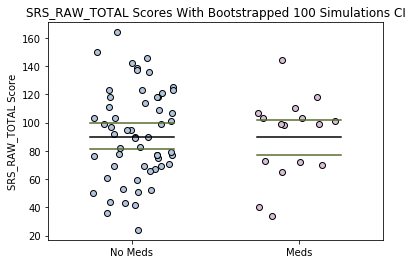

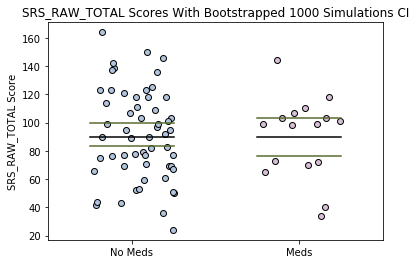

In [813]:
# calculating means
meanNoMed = np.mean(ASD_NoMeds_SRS)
meanMed = np.mean(ASD_Meds_SRS)
# create bootstrap samples for 100
boot_NoMed_100 =[]
boot_Med_100 = []
for i in range (100):
        NoMed_boot=np.random.choice(ASD_NoMeds_SRS,len(ASD_NoMeds_SRS),replace=True)
        Med_boot=np.random.choice(ASD_Meds_SRS,len(ASD_Meds_SRS),replace= True)
        NoMed_boot_mean = np.mean(NoMed_boot)
        Med_boot_mean = np.mean(Med_boot)
        boot_NoMed_100.append(NoMed_boot_mean)
        boot_Med_100.append(Med_boot_mean)

# create bootstrap samples for 1000
boot_NoMed_1000 =[]
boot_Med_1000 = []
for i in range (1000):
        NoMed_boot=np.random.choice(ASD_NoMeds_SRS,len(ASD_NoMeds_SRS),replace=True)# not sure what sample to use so I juut used 15
        Med_boot=np.random.choice(ASD_Meds_SRS,len(ASD_Meds_SRS),replace= True)
        NoMed_boot_mean = np.mean(NoMed_boot)
        Med_boot_mean = np.mean(Med_boot)
        boot_NoMed_1000.append(NoMed_boot_mean)
        boot_Med_1000.append(Med_boot_mean)

        
# RUNNING SIMULATIONS        
        
        
# 100 simulations
# sort the data
boot_NoMed_100.sort()
#find the quantiles
lower1nomed = int(0.025*len(boot_NoMed_100))
upper1nomed = int(0.975*len(boot_NoMed_100))
lower_bound1nomed = boot_NoMed_100[lower1nomed]
upper_bound1nomed = boot_NoMed_100[upper1nomed+1]
con_int1 = upper_bound1nomed-lower_bound1nomed
print("100 Simulations, No Medication: The 95% confidence interval is from",lower_bound1nomed,"to",upper_bound1nomed)
# sort the data
boot_Med_100.sort()
# find the quantiles
lower1med = int(0.025*len(boot_Med_100))
upper1med =int(0.975*len(boot_Med_100))
lower_bound1med=boot_Med_100[lower1med]
upper_bound1med=boot_Med_100[upper1med+1]
con_int1 = upper_bound1med-lower_bound1med
print("100 Simulations, Medication: The 95% confidence interval is from",lower_bound1med,"to",upper_bound1med)

# 1000 simulations
# sort the data
boot_NoMed_1000.sort()
#find the quantiles
lower2nomed = int(0.025*len(boot_NoMed_1000))
upper2nomed =int(0.975*len(boot_NoMed_1000))
lower_bound2nomed=boot_NoMed_1000[lower2nomed]
upper_bound2nomed=boot_NoMed_1000[upper2nomed+1]
con_int2 = upper_bound2nomed-lower_bound2nomed
print("1000 Simulations, No Medication: The 95% confidence interval is from",lower_bound2nomed,"to",upper_bound2nomed)
#sort the data
boot_Med_1000.sort()
#find the quantiles
lower2med = int(0.025*len(boot_Med_1000))
upper2med =int(0.975*len(boot_Med_1000))
lower_bound2med=boot_Med_1000[lower2med]
upper_bound2med=boot_Med_1000[upper2med+1]
con_int2 = upper_bound2med-lower_bound2med
print("1000 Simulations, Medication: The 95% confidence interval is from",lower_bound2med,"to",upper_bound2med)


# PLOTTING


# placing in confidence intervals and means by horizontal arrays
# around 1
array1 = [2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5]
# for 100, means, CI
lower100_1 = [lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med, lower_bound1med]
mean100_1 = [meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed]
upper100_1 = [upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med, upper_bound1med]
# for 1000, means, CI
lower1000_1 = [lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med, lower_bound2med]
mean1000_1 = [meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed]
upper1000_1 = [upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med, upper_bound2med] 
# around 2 
array2 = [x - 2 for x in array1]
# for 100, means, CI
lower100_2 = [lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed, lower_bound1nomed]
mean100_2 = [meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed, meanMed]
upper100_2 = [upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed, upper_bound1nomed]
# for 1000, means, CI
lower1000_2 = [lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed, lower_bound2nomed]
mean1000_2 = [meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed, meanNoMed]
upper1000_2 = [upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed, upper_bound2nomed]
    
# Creating the strip plot for 100 simulations
x_NoMeds = [0.5] * len(ASD_NoMeds_SRS) + np.random.random_sample(len(ASD_NoMeds_SRS))
x_Meds = [2.5] * len(ASD_Meds_SRS) + np.random.random_sample(len(ASD_Meds_SRS))
plt.plot(x_NoMeds, ASD_NoMeds_SRS, color = 'lightsteelblue', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(x_Meds, ASD_Meds_SRS, color = 'thistle', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(array1, lower100_1, color = 'darkolivegreen', label = 'Upper')
plt.plot(array1, upper100_1, color = 'darkolivegreen', label = 'Lower')
plt.plot(array1, mean100_1, color = 'black', label = 'Mean')
plt.plot(array2, lower100_2, color = 'darkolivegreen')
plt.plot(array2, upper100_2, color = 'darkolivegreen')
plt.plot(array2, mean100_2, color = 'black')
plt.xlim(0,4)
plt.xticks(range(1, 4, 2), ['No Meds', 'Meds'])
plt.ylabel('SRS_RAW_TOTAL Score')
plt.title('SRS_RAW_TOTAL Scores With Bootstrapped 100 Simulations CI')
plt.legend
plt.show()

# Creating the strip plot for 1000 simulations
x_NoMeds = [0.5] * len(ASD_NoMeds_SRS) + np.random.random_sample(len(ASD_NoMeds_SRS))
x_Meds = [2.5] * len(ASD_Meds_SRS) + np.random.random_sample(len(ASD_Meds_SRS))
plt.plot(x_NoMeds, ASD_NoMeds_SRS, color = 'lightsteelblue', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(x_Meds, ASD_Meds_SRS, color = 'thistle', marker = 'o', linestyle = 'None', markeredgecolor='black')
plt.plot(array1, lower1000_1, color = 'darkolivegreen', label = 'Upper')
plt.plot(array1, upper1000_1, color = 'darkolivegreen', label = 'Lower')
plt.plot(array1, mean100_1, color = 'black', label = 'Mean')
plt.plot(array2, lower1000_2, color = 'darkolivegreen')
plt.plot(array2, upper1000_2, color = 'darkolivegreen')
plt.plot(array2, mean100_2, color = 'black')
plt.xlim(0,4)
plt.xticks(range(1, 4, 2), ['No Meds', 'Meds'])
plt.ylabel('SRS_RAW_TOTAL Score')
plt.title('SRS_RAW_TOTAL Scores With Bootstrapped 1000 Simulations CI')
plt.legend
plt.show()


Essay Portion:

The sample size used in each of the bootstrapping procedues with replacement is the largest parameter which is available to us. <br> 
<br>
This confidence interval is the area in which we are 95% confident that the mean exists in. <br>
<br>
Effect size refers to the quantitative measure of the magnitude of the effect of the experimenter, allowing us to understand the size of the difference that we gather. The p-value we obtain shows us that we may expect a larger effect size. The difference in the means is the test statistic we are testing, which we compare with the null test statistic to produce a p-value that would give us evidence when evaluating our null and alternative hypotheses. <br> 
<br>
Bootstrapping can be used to compute the standard error and 95% confidence intervals because we can approximate the sampling distribution of an estimated value and can also obtain a standard error without a given formula or when we don’t fully know the sampling distribution. Using the random sampling methods with bootstrapping lets us assign specific measures of accuracy on various parameters. <br> 
<br>
I don't believe that 1,000 is enough simulations. This is because it still does not give us a clear idea of the difference (still ouputs a large range that doesn't quite give us a clear idea). 10,00 simulations would be better for this. 


### 3.10  Logistic Regression

Data Science Portion:

Accuracy = 0.5266666666666666
0.587
Node At Which We Get Highest Accuracy: Node 31
Category At Which We Get Highest Accuracy: Column 1 , which corresponds to VIQ.
[0.6, 0.627, 0.547, 0.593, 0.527]


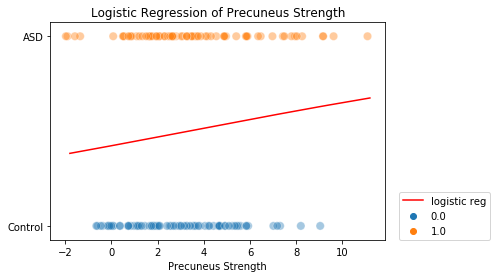

In [815]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import column_or_1d
# precuneus = 76th node in matrix, but since Python starts at 0, we use 75th column for this
# adding precuneus to phenotypic data frame
n_nodes = 160
phenotypic = abide.phenotypic
precuneus = []
for x in range(0, len(phenotypic)):
    connEst = conn_est[x] # getting specific 160x160 matrix for the subject
    precuneus_subject = sum(connEst[:, 75])
    precuneus.append(precuneus_subject)
phenotypic = pd.DataFrame(phenotypic)
phenotypic['precuneus'] = precuneus
# separating phenotypic data between control and ASD
control = phenotypic[phenotypic['DX_GROUP']==2]
ASD = phenotypic[phenotypic['DX_GROUP']==1]
# obtaining precuneus's per group
control_precuneus = control['precuneus']
ASD_precuneus = ASD['precuneus']

# converting control to 0s
controlArray = np.zeros(len(control_precuneus))
controlArray = controlArray.tolist()
controlPrecuneus = control_precuneus.tolist()
# converting ASD to 1s
ASDArray = [x + 1 for x in np.zeros(len(ASD_precuneus))] 
ASDPrecuneus = ASD_precuneus.tolist()
fullArray = controlArray + ASDArray
fullArray = np.array(fullArray)
fullPrecuneus = controlPrecuneus + ASDPrecuneus
fullPrecuneus = np.array(fullPrecuneus)

# Now let's do the logistic regression!
model = LogisticRegression(random_state=0).fit(fullPrecuneus.reshape(-1,1), column_or_1d(fullArray, warn =True))
# Now have the model compute the expected proportions of 1s at each value of x
y_hats_logit = model.predict_proba(fullPrecuneus.reshape(-1,1))[:,1]

# Plot the original data and the prediction from the logistic regression
z = [0, 1] 
labels = ["Control", "ASD"]
sns.scatterplot(fullPrecuneus + 0.2*np.random.normal(size=fullPrecuneus.size), fullArray, hue = fullArray, s=70, alpha = 0.4)
plt.xlabel("Precuneus Strength")
sns.lineplot(fullPrecuneus, y_hats_logit, color = "red", label = "logistic reg")
plt.yticks(z, labels, rotation='horizontal')
plt.legend(loc=(1.04, 0))
plt.title('Logistic Regression of Precuneus Strength')

# We can evaluate the accuracy of our model using model.score.
print(f'Accuracy = {model.score(fullPrecuneus.reshape(-1,1), fullArray)}')

conn_control = conn_est[phenotypic['DX_GROUP']==2]
conn_ASD = conn_est[phenotypic['DX_GROUP']==1]

def getaccuracynode(node):
    control_prec = []
    ASD_prec = []
    for i in range(len(conn_control)):
        matrix = conn_control[i]
        cumsum = sum(matrix[:, node])
        control_prec.append(cumsum)
    for i in range(len(conn_ASD)):
        matrix = conn_ASD[i]
        cumsum = sum(matrix[:, node])
        ASD_prec.append(cumsum)
    data_vec = [0]*len(conn_control)
    ones = [1]*len(conn_ASD)
    data_vec.extend(ones)
    control_prec.extend(ASD_prec)
    x_vals_exp = control_prec
    x_vals_exp = np.array(x_vals_exp)
    data_vec = np.array(data_vec)
    model = LogisticRegression(random_state=0).fit(x_vals_exp.reshape(-1,1), data_vec)
    y_hats_logit = model.predict_proba(x_vals_exp.reshape(-1,1))[:,1]
    Accuracy = model.score(x_vals_exp.reshape(-1,1), data_vec)
    Accuracy = round(Accuracy, 3)
    return Accuracy

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

AccStore = []
for j in range(150):
    Acc = getaccuracynode(j)
    AccStore.append(Acc)
print(max(AccStore))
print('Node At Which We Get Highest Accuracy: Node', AccStore.index(max(AccStore))+1)

# Iterate over given columns only from the dataframe
accurastore = []
for column in phenotypic[['FIQ', 'VIQ', 'PIQ', 'SRS_RAW_TOTAL', 'AGE_AT_SCAN']]:
    x_vals_exp = phenotypic[column]
    x_vals_exp = np.array(x_vals_exp)
    data_vec = 1*(phenotypic['DX_GROUP'] ==1)
    model = LogisticRegression(random_state=0).fit(x_vals_exp.reshape(-1,1), data_vec)
    y_hats_logit = model.predict_proba(x_vals_exp.reshape(-1,1))[:,1]
    Accuracy = model.score(x_vals_exp.reshape(-1,1), data_vec)
    Accuracy = round(Accuracy, 3)
    accurastore.append(Accuracy)
    
print('Category At Which We Get Highest Accuracy: Column', accurastore.index(max(accurastore)), ', which corresponds to VIQ.')
    
print(accurastore)

warnings.filterwarnings("default", category=FutureWarning)

Essay Portion:

We learned that classifying those with ASD from our results is only partly quantifiable. There is still room for error with the most accurate method. It wasn't necessarily difficult to find a better predictor since we used many of the methods in previous questions; we just had to implement the usage of accuracy from logistic regression to differentiate ASD and control. In total, there were 164 possible indicators. These included the 160 nodes, FIQ, VIQ, PIQ, and the SRS_RAW_TOTAL. I tried all of these predictors. We found that the best indicator was the VIQ, followed by the 31st node. As we evaluate more predictors, we should be more concerned about committing Type I error, since this is rejecting a true null hypothesis. In our case, since the accuracy isn't quite high enough to always be accepted, we may mistakely reject a true null hypothesis. 